# Indian Institute of Technolgy, Ropar
# B. Tech Project
## Prediction of costs for EV charging
### Team Members
* Yash Jain - 2019EEB1208
* Swapnil Saurav - 2019EEB1204
* Aishwarya Pal - 2019EEB1136

Under the Guidance of Dr. K. R. Sekhar and Nikhil.

Department of Electrical Engineering.

The overall Project is broken into subparts as follows:
1. Prediction of Irradiance from current weather data.
2. Prediction of Power from Irradiance and Temperature.
3. Estimation of cost of EV charging from grid and solar power availability.

We have used ML for the first two parts. 



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# for data handeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for the model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

# for API handeling
import requests
import json
from datetime import datetime
from pytz import timezone

# for saving model
from joblib import Parallel, delayed
import joblib

In [3]:
# loading the datasets
root = "/content/gdrive/MyDrive/BTP sem7 Group 2/ropar_model/"

ropardata = pd.read_csv(root+'ropar_data_final.csv')
matdata = pd.read_csv(root+'matdata.csv')

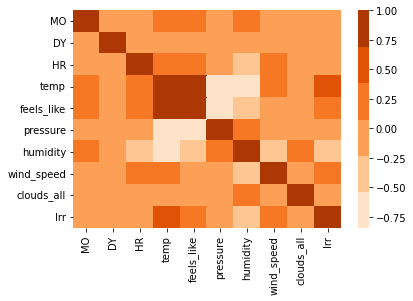

In [4]:
correlation = ropardata.corr(method = 'pearson')
sns.heatmap(correlation, cmap=sns.color_palette("Oranges"))

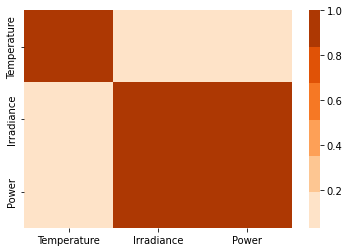

In [5]:
correlation = matdata.corr(method = 'pearson')
sns.heatmap(correlation, cmap=sns.color_palette("Oranges"))

In [18]:
# The below function will create the model, split the data, fit the model and checks the accuracies.
def model_maker(data,key):
    # creating the model.
    regressor = ExtraTreesRegressor(n_estimators = 100)

    # extracting X and Y from the data.
    df2 = data.iloc[:,:-1]
    X = df2.to_numpy()
    Y = data[key].to_numpy()

    # X_train and Y_train for training the model. X_test, Y_test for testing.
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.80, random_state=1)

    #fitting the model
    regressor.fit(X_train, Y_train)

    # Calcuting the accuracies
    accuracies = cross_val_score(estimator = regressor, X = X_train,y = Y_train, cv = 2, scoring = 'r2')
    accuracy = accuracies.mean()
    print('\n--------------------------------------------------\n')
    print('From Training Data:')
    print(f'r2 = {accuracy}\n')


    # predicting radiance and accuracy calculation
    y_pred = regressor.predict(X_test)
    explained_variance_score2 = explained_variance_score(Y_test, y_pred)
    mean_squared_error2 = mean_squared_error(Y_test, y_pred)
    r_squared = r2_score(Y_test, y_pred)

    
    print('From Testing Data:')
    print(f'explained variance = {explained_variance_score2}')
    print(f'mse = {mean_squared_error2}')
    print(f'r2 = {r_squared}')

    plt.plot(Y_test[:50])
    plt.plot(y_pred[:50])
    plt.show()
    print('\n--------------------------------------------------\n')
    return regressor


--------------------------------------------------

From Training Data:
r2 = 0.9948491449579064

From Testing Data:
explained variance = 0.9957524630281337
mse = 441.6975659953794
r2 = 0.9957504568110758


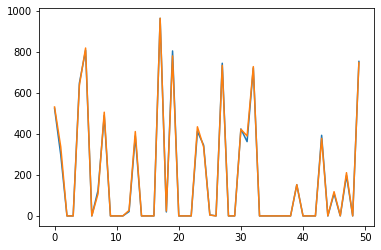


--------------------------------------------------


--------------------------------------------------

From Training Data:
r2 = 0.9550085443605281

From Testing Data:
explained variance = 0.9995323244413135
mse = 5.072439107075705
r2 = 0.9994711274932148


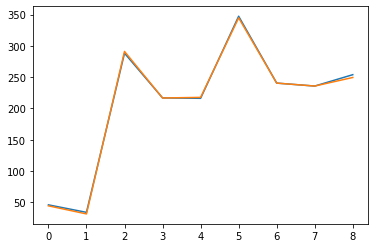


--------------------------------------------------



In [21]:
# creating the models for irradiance and voltage.
roparmodel = model_maker(ropardata,'Irr')

matmodel = model_maker(matdata,'Power')



In [22]:
# The below function handles the API call.
def API_handler(lat=30.9688367,lon=76.526088):

    dd = datetime.now(timezone('Asia/Kolkata'))
    month = dd.month
    day = dd.day
    hour = dd.hour

    url = "https://api.openweathermap.org/data/2.5/weather?lat="+str(lat)+"&lon="+str(lon)+"&appid=2865c640108f7ea2169c32049fb48227"
    response = requests.get(url)

    if response.status_code == 200:
        print("Sucessfully fetched the data from the API.")
    else:
        print(f"Hello User!, there's a {response.status_code} error with your request. Can not fetch the data.")

    fetched_data = response.json()
    # print(json.dumps(fetched_data, indent = 3))

    temp = fetched_data['main']['temp']
    feels_like = fetched_data['main']['feels_like']
    pressure = fetched_data['main']['pressure']
    humidity = fetched_data['main']['humidity']
    wind_speed = fetched_data['wind']['speed']
    clouds = fetched_data['clouds']['all']

    return np.array([[month,day, hour, temp, feels_like, pressure, humidity, wind_speed, clouds]])

In [23]:
# Calling the API and printing the data
api_data = API_handler(14.35,7.55)

print(f"Month: {api_data[0][0]} \nDay: {api_data[0][1]} \nhour: {api_data[0][2]}")
print(f"Temperature: {api_data[0][3]} \nFeels_Like: {api_data[0][4]} \nPressure: {api_data[0][5]}")
print(f"Humidity: {api_data[0][6]} \nWind Speed: {api_data[0][7]} \nClouds: {api_data[0][8]}")

# Predict Irradiance
irr = roparmodel.predict(api_data)
print("Irradiance:", irr[0])

# Predict Power
x = [[api_data[0][3]-273.15, irr[0]]]
# print(x)
pow = matmodel.predict(x)
print("Expected Power:", pow)

Sucessfully fetched the data from the API.
Month: 2.0 
Day: 4.0 
hour: 21.0
Temperature: 307.49 
Feels_Like: 304.89 
Pressure: 1009.0
Humidity: 9.0 
Wind Speed: 4.27 
Clouds: 80.0
Irradiance: 4.5419
Expected Power: [10.8114]


1.3198416000000022
t_ch = 1.0 , cost = 200.0
t_ch = 1.1 , cost = 202.41992721518952
t_ch = 1.2 , cost = 204.83985443037895
t_ch = 1.3 , cost = 207.25978164556847
t_ch = 1.4 , cost = 209.6797088607579
t_ch = 1.5 , cost = 212.0996360759474
t_ch = 1.6 , cost = 214.51956329113688
t_ch = 1.7 , cost = 216.93949050632634
t_ch = 1.8 , cost = 219.35941772151585
t_ch = 1.9 , cost = 221.7793449367053
t_ch = 2.0 , cost = 224.1992721518948
t_ch = 2.1 , cost = 226.61919936708432
t_ch = 2.2 , cost = 229.0391265822738
t_ch = 2.3 , cost = 231.45905379746318
t_ch = 2.4 , cost = 233.87898101265267
t_ch = 2.5 , cost = 236.2989082278422
t_ch = 2.6 , cost = 238.7188354430317
t_ch = 2.7 , cost = 241.13876265822117
t_ch = 2.8 , cost = 243.55868987341057
t_ch = 2.9 , cost = 245.9786170886001
t_ch = 3.0 , cost = 248.3985443037896
t_ch = 3.1 , cost = 250.8184715189791
t_ch = 3.2 , cost = 253.2383987341686
t_ch = 3.3 , cost = 255.65832594935802
t_ch = 3.4 , cost = 258.0782531645475
t_ch = 3.5 , cost = 260.4981803

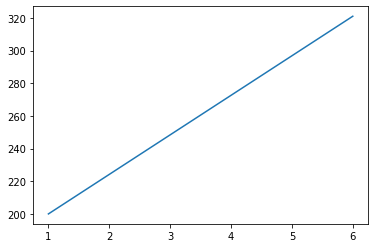

In [10]:
num_panels = 100
Ps = pow[0]*num_panels/1000   # kW
print(Ps)
Pg = 40
Ereq = 40
t = []
c = []
# print(t)

for i in range(0,51):

    t_ch = 1 + i/10       # hrs
    
    # x*Ps + (t_ch - x)Pg = Ereq
    x = (Ereq - t_ch*Pg)/(Ps - Pg)

    solarcost = 30
    gridcost = 200

    if(x>t_ch):
        break
        
    cost = x*solarcost + (t_ch-x)*gridcost

    t.append(t_ch)
    c.append(cost)
    print("t_ch =", t_ch, ", cost =",cost)
    # print(x*Ps,(t_ch-x)*Pg)

plt.plot(t,c)

In [16]:
joblib.dump(roparmodel, root + 'ropar_model.pkl')
load_model = joblib.load( root + 'ropar_model.pkl')

print(load_model.predict(api_data))

[0.8271]
